In [1]:
### using (7.64a), which f0*\bar{v*} + \bar{v'q'} equal m (v* mean vTEM)
import numpy as np
import matplotlib.pyplot as plt
import h5py
import multiprocessing
from multiprocessing import Pool
import os
import matplotlib.cm as cm

In [2]:
class Dycore:
    def __init__(self, file):
        self.ds = h5py.File(file, "r")
        
    def getVar(self, var):
        return np.asarray(self.ds[var])

In [3]:
# read variables
from scipy.fftpack import fft,ifft,fftfreq
file  = f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

dycore = Dycore(file)
u  = dycore.getVar("grid_u_c_xyzt")
v  = dycore.getVar("grid_v_c_xyzt")
t  = dycore.getVar("grid_t_c_xyzt")
ps = dycore.getVar("grid_ps_xyzt")
p  = dycore.getVar("grid_p_full_xyzt")
sigma = p / ps
sigma_mean  = np.nanmean(sigma, axis=(0,3))
sigma_onlyz = np.nanmean(sigma_mean, axis=1)
Rd = 287
cp = 1004
g = 9.81
theta      = t * (ps / p)**(Rd/cp)
H = 6800
a = 6.37122e6

In [4]:
# The edition without time mean
def plot_V_W_50(pr):
    file  = f"HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

    dycore = Dycore(file)
    # u  = dycore.getVar("grid_u_c_xyzt")
    v  = dycore.getVar("grid_v_c_xyzt")
    t  = dycore.getVar("grid_t_c_xyzt")
    ps = dycore.getVar("grid_ps_xyzt")
    p  = dycore.getVar("grid_p_full_xyzt")
    sigma = p / ps
    sigma_mean = np.nanmean(sigma, axis=(0,3))
    sigma_onlyz = np.nanmean(sigma_mean, axis=1)
    Rd = 287
    cp = 1004
    g = 9.81
    theta             = t * (ps / p)**(Rd/cp)
    H = 6800
    # p0 = 100000
    a = 6.37122e6
    
    # calculate rho_0 = exp(-Z/H) using Z = Hln(P0/P)
    # Z = H * np.log(np.nanmean(p0/p, axis=(0,3)))
    # Z_all     = H * np.log(p0/p)
    rho_0     = np.zeros((20,64))
    rho_0_all = np.zeros(((500,20,64)))
    for i in range(0,20):
        rho_0[i,:] =   np.nanmean(p, axis=(0,3))[i,:] / np.nanmean(ps, axis=(0,3))[0,:] # np.exp(-Z[i,:]/H) 
        rho_0_all[:,i,:] = np.nanmean(p[:,i,:,:], axis=2) / np.nanmean(ps[:,0,:,:], axis=2)                  # np.exp(-Z_all[:,i,:,:]/H) 
    omega  = (dycore.getVar("grid_w_full_xyzt"))
    w = omega  
    ### do dz by dz = H * ln(ps/p)
    THzm = np.nanmean(theta, axis=(3)) ######################
    THETAz  = np.zeros(((500,20,64))) ############ 
    p_onlyz = np.nanmean(p, axis=(0,2,3))
    for i in range(1,19):
        THETAz[:,i,:] = (THzm[:,i+1,:] - THzm[:,i-1,:]) / (p_onlyz[i+1] - p_onlyz[i-1]) #########
    THETAz[:,0,:]  = (THzm[:,1,:]  - THzm[:,0,:])  /  (p_onlyz[1] - p_onlyz[0])
    THETAz[:,-1,:] = (THzm[:,-1,:] - THzm[:,-2,:]) /  (p_onlyz[-1] - p_onlyz[-2])
    
    THETAz[THETAz == 0] = np.nan # just in cast divide by zero 
    
    Vza = np.zeros(u.shape)
    THETAza = np.zeros(u.shape)
    Wza = np.zeros(u.shape)
    
    Vzm = np.nanmean(v, axis=3)
    THzm = np.nanmean(theta, axis=3)
    for i in range(0,128):
        Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
        THETAza[:,:,:,i] = theta[:,:,:,i] - THzm
        
    VTHETA = Vza * THETAza
    VTHzm = np.nanmean(VTHETA, axis=3)  ### mean lon
    # VTHzmtm = np.nanmean(VTHzm, axis=0) ### mean time
    
    Wzm = np.nanmean(w, axis=3)
    Wzmtm = np.nanmean(Wzm, axis=0)
    Vzm = np.nanmean(v, axis=(3)) #########
    
    # phi
    lat   = np.linspace(-90, 90, 64)
    phi = np.broadcast_to(np.deg2rad(lat).reshape(1,64),(20,64)) # Get latitude in radians
    lat_new = np.broadcast_to(lat.reshape(1,64),(20,64)) # Get latitude in radians
    
    cphi  = np.cos(phi) 
    acphi = a * cphi

    # calculate vTEM = v - 1/rho0 d/dz(rho0 v'Th'/THz)    
    vTEM_temp = rho_0_all * VTHzm / THETAz ############################################
    vTEM_tempdz = np.zeros(((500,20,64)))
    for i in range(1,19):
        vTEM_tempdz[:,i,:] = (vTEM_temp[:,i+1,:] - vTEM_temp[:,i-1,:]) /  (p_onlyz[i+1] - p_onlyz[i-1])
    vTEM_tempdz[:,0,:]  = (vTEM_temp[:,1,:]  - vTEM_temp[:,0,:]) /  (p_onlyz[1] - p_onlyz[0])
    vTEM_tempdz[:,-1,:] = (vTEM_temp[:,-1,:] - vTEM_temp[:,-2,:]) / (p_onlyz[-1] - p_onlyz[-2])
    
    vTEM1 = Vzm #################
    vTEM2 = (1/rho_0_all) * vTEM_tempdz
    vTEM  = vTEM1 - vTEM2
    # calculate wTEM = w + 1/(acosphi) d/d(phi) (cosphi v'TH'/THz)
    wTEM_temp =  cphi * VTHzm / THETAz ############################################
    wTEM_tempdphi = np.zeros(((500,20,64)))
    for i in range(1,63):
        wTEM_tempdphi[:,:,i] = (wTEM_temp[:,:,i+1] - wTEM_temp[:,:,i-1]) / (phi[:,i+1] - phi[:,i-1])
    wTEM_tempdphi[:,:,0]  = (wTEM_temp[:,:,1] - wTEM_temp[:,:,0]) /  (phi[:,1]  - phi[:,0])
    wTEM_tempdphi[:,:,-1] = (wTEM_temp[:,:,-1] - wTEM_temp[:,:,-2]) / (phi[:,-1] - phi[:,-2])
    
    wTEM1 = Wzm ##################
    wTEM2 = (wTEM_tempdphi) /acphi
    wTEM = wTEM1 + wTEM2

    return vTEM,wTEM,p, ps, Wzmtm, rho_0
vTEM, wTEM,p, ps, Wzmtm, rho_0 = plot_V_W_50(10)
print("over")


over


In [5]:
print(vTEM.shape)
# cal zonal mean and zonal anamoly
Vzm = np.nanmean(v, axis=3)
Uzm = np.nanmean(u, axis=3)
Vza = np.zeros(u.shape)
Uza = np.zeros(u.shape)

x = np.linspace(-180,180,128)
y = np.linspace(-90,90,64)
xd = np.deg2rad(x)
yd = np.deg2rad(y)

for i in range(0,128):
    Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
    Uza[:,:,:,i]     = u[:,:,:,i] - Uzm  

(500, 20, 64)


In [6]:
# WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
cy = np.cos(yd)
cy [0] = np.nan
cy [-1] = np.nan

In [7]:
### try to calculate balanced partial u partial t, which is calculated by TEM equation.
# first calculate zonal (v'q') (q is potential vorticity)
v  = dycore.getVar("grid_v_c_xyzt")
u  = dycore.getVar("grid_u_c_xyzt")
p  = dycore.getVar("grid_p_full_xyzt")
ps = dycore.getVar("grid_ps_xyzt")
t  = dycore.getVar("grid_t_c_xyzt")
Rd = 287
cp = 1004

theta = t * (ps / p)**(Rd/cp)

Vzm = np.nanmean(v, axis=3)
Uzm = np.nanmean(u, axis=3)
THzm = np.nanmean(theta, axis=3)
# THvm = np.nanmean(theta, axis=1)
Pzm = np.nanmean(p, axis=3)
Tzm = np.nanmean(t, axis=3)

In [8]:
Vzmtm  = np.nanmean(Vzm, axis=0)
Uzmtm  = np.nanmean(Uzm, axis=0)
THzmtm = np.nanmean(THzm, axis=0)
# THvmtm = np.nanmean(THvm, axis=0)
Pzmtm  = np.nanmean(Pzm, axis=0)
Tzmtm  = np.nanmean(Tzm, axis=0)

Vza     = np.zeros(u.shape)
Uza     = np.zeros(u.shape)
THETAza = np.zeros(u.shape)
Pza = np.zeros(u.shape)
Tza = np.zeros(t.shape)

for i in range(0,128):
    Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
    Uza[:,:,:,i]     = u[:,:,:,i] - Uzm
    THETAza[:,:,:,i] = theta[:,:,:,i] - THzm
    Pza[:,:,:,i]     = p[:,:,:,i] - Pzm
    Tza[:,:,:,i]     = t[:,:,:,i] - Tzm
    
M = Uza * Vza
Mzm = np.nanmean(M, axis=(3))

for i in range(1,64-1):
    Mzm[:,:,i] = cy[i]**0.5 * Mzm[:,:,i]

dmdy = np.zeros(((500,20,64)))
r = 6371e3
for i in range(1,64-1):
    dmdy[:,:,i] = -(Mzm[:,:,i+1] - Mzm[:,:,i-1]) / (r * (yd[i+1] - yd[i-1]))
dmdy[:,:, 0] = -(Mzm[:,:, 1] - Mzm[:,:, 0]) / (r*(yd[ 1] - yd[ 0]))
dmdy[:,:,-1] = -(Mzm[:,:,-1] - Mzm[:,:,-2]) / (r*(yd[-1] - yd[-2]))
print(dmdy.shape)

(500, 20, 64)


Text(0.5, 1.0, "$\\overline{u'v'}$")

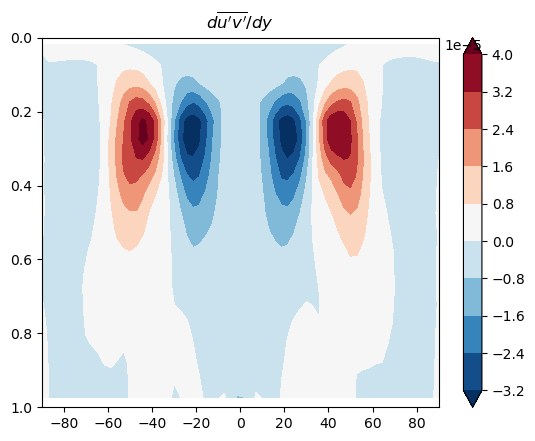

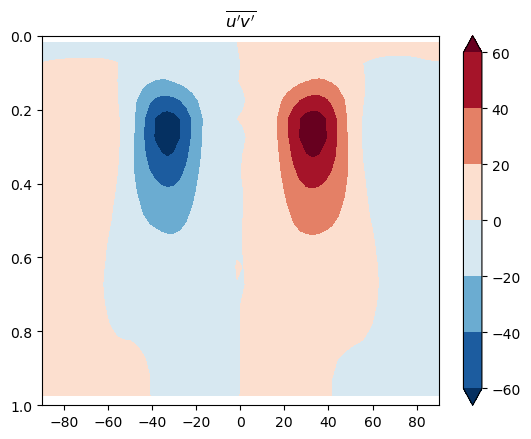

In [9]:
sigma_mean      = np.nanmean(p/ps, axis=(0,3))
sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
y               = np.linspace(-90,90,64)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)
# vq_yz = np.nanmean(Vza * qza, axis=(0,3))

plt.figure()
plt.contourf(yy, sigma_mean2,  np.nanmean(dmdy, axis=0), levels= 11, cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar()
plt.title("$d\overline{u'v'} / dy$")

plt.figure()
plt.contourf(yy, sigma_mean2,  np.nanmean(Mzm, axis=0), cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar()
plt.title("$\overline{u'v'}$")

(500, 20, 64, 128)
(500, 20, 64, 128)


Text(0.5, 1.0, "$\\overline{v'b'}$")

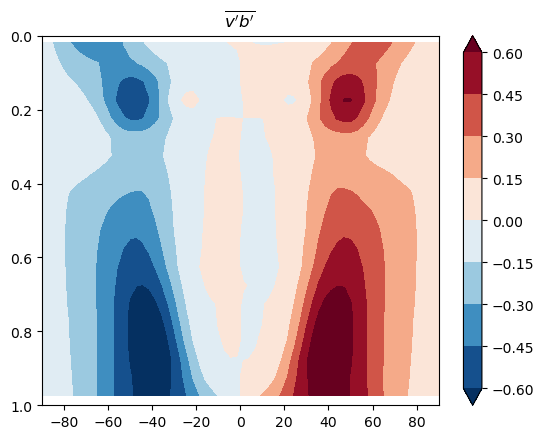

In [10]:
f0  = 2 * 7.292E-5 * np.sin(yd)
print(THETAza.shape)
# for i in range
# first mean y, then do three loop
bza =  THETAza / np.nanmean(theta, axis=0) * 9.81
print(bza.shape)
plt.figure()
plt.contourf(yy, sigma_mean2, np.nanmean(Vza * bza , axis=(0,3)),levels=11, cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar()
plt.title("$\overline{v'b'}$")

In [11]:
from scipy.interpolate import interp1d
sigma_mean      = np.nanmean(p/ps, axis=(0,3))
sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
y               = np.linspace(-90,90,64)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)

### ex z, ex theta, check plot z and theta, then cal N_square
# do ex z
from scipy import interpolate
N_square   = np.zeros(((500,20,64,128)))
# t is t\bar (z)
z = np.zeros(u.shape)
print(np.arange(-1,21))
for i in range(1,20-1):
    z[:,i,:,:] = Rd*np.nanmean(t[:,0:i+1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
z[:, 0,:,:] = Rd*np.nanmean(t[:,0: 1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,1,:,:])
z[:,-1,:,:] = Rd*np.nanmean(t[:,:,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,-1,:,:])
##########
Pvm      = np.nanmean(p, axis=(0,2,3))

# print(z[0])
z_new = np.zeros((((500,22,64,128))))
theta_new = np.zeros((((500,22,64,128))))

for i in range(500):
    for j in range(64):
          for k in range(128):
            fe            = interp1d(np.linspace(0,20,20),z[i,:,j,k],  fill_value='extrapolate')
            z_new[i,:,j,k] = fe(np.linspace(-1,21,22))
            fe            = interp1d(np.linspace(0,20,20),theta[i,:,j,k],  fill_value='extrapolate')
            theta_new[i,:,j,k] = fe(np.linspace(-1,21,22))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


172.34413431737167


Text(0.5, 1.0, 'theta and theta exterpolate')

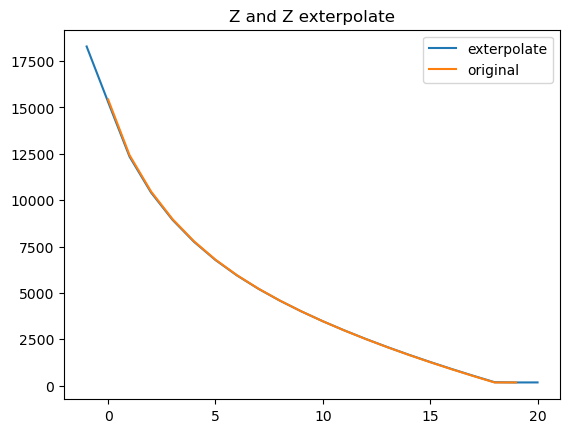

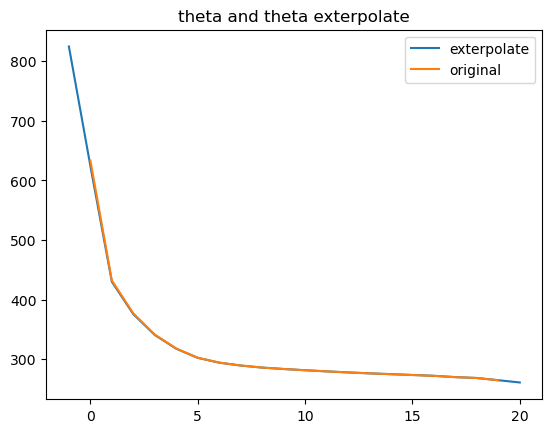

In [12]:
plt.figure()
plt.plot(np.arange(-1, 21), z_new[200,:,0,0], label='exterpolate')
print(z[200,-1,0,0])
plt.plot(np.arange( 0, 20), z[200,:,0,0], label='original')
plt.legend()
# plt.ylim([1,0])
# plt.colorbar()
# plt.title("N^2")
plt.title("Z and Z exterpolate")

plt.figure()
plt.plot(np.arange(-1, 21),theta_new[200,:,0,0], label='exterpolate')
plt.plot(np.arange( 0, 20),theta[200,:,0,0], label='original')
plt.legend()

plt.title("theta and theta exterpolate")

(500, 17, 64, 128)
over


Text(0.5, 1.0, 'N^2')

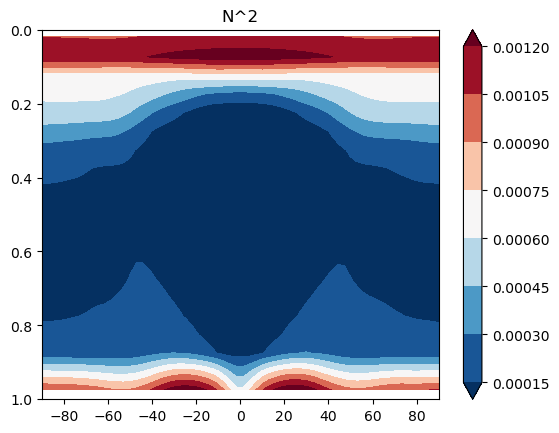

In [13]:
for i in range(1,20-1):
    N_square[:,i,:,:]   = 9.81 / theta[:,i,:,:] * (theta[:,i+1,:,:] - theta[:,i-1,:,:]) / (z[:,i+1,:,:]-z[:,i-1,:,:]) # original is partial z, but Dycore is on pressure (sigma) coord. so add minus
print(t[:,0:i-1,:,:].shape)

N_square[:, 0,:,:] = 9.81 / theta_new[:, 1,:] * (theta_new[:, 2,:] - theta_new[:, 0,:]) / (z_new[:,2,:,:]-z_new[:,0,:,:])

N_square[:,19,:,:] = 9.81 / theta_new[:,21,:,:] * (theta_new[:,21,:,:] - theta_new[:,18,:,:]) / (z_new[:,21,:,:]-z_new[:,18,:,:])
print("over")
# print(N_square[:,19,:,:])
# print(N_square[:,18,:,:])

plt.figure()
plt.contourf(yy, sigma_mean2, np.nanmean(N_square, axis=(0,3)),levels=11, cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar()
plt.title("N^2")

(500, 20, 64)


Text(0.5, 1.0, "$\\overline{v'b'} / N^2 $")

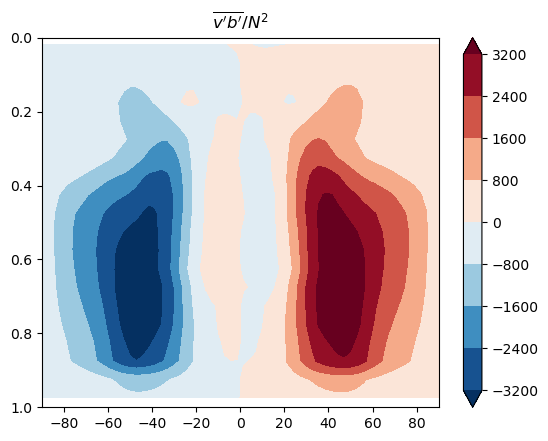

In [14]:
### edited for EOF, changing the dimension to (500, 20, 64) to do baroclinc annular mode
# MHF = np.nanmean(Vza * bza, axis=(0,3)) / np.nanmean(N_square, axis=(0,3))
MHF = np.nanmean(Vza * bza, axis=3) / np.nanmean(N_square, axis=3)

MHF_f = np.zeros(MHF.shape) # mean meridional heat flux 
p_mean = np.nanmean(p, axis=3)
for i in range(64):
    MHF_f[:,:,i] = MHF[:,:,i] * f0[i]
print(MHF.shape)

plt.figure()
plt.contourf(yy, sigma_mean2,  np.nanmean(MHF, axis=0), levels=11, cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar()
plt.title("$\overline{v'b'} / N^2 $")


[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
(500, 20, 64, 128)
0.0022901951284394345


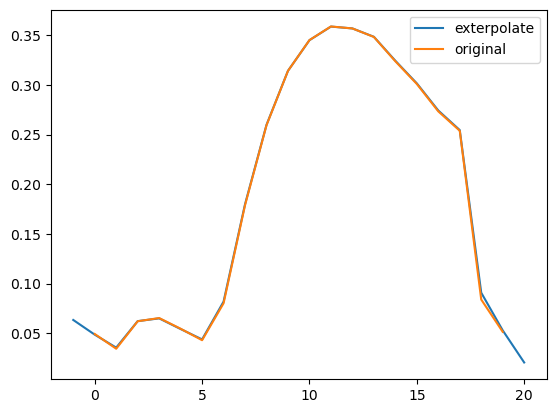

In [15]:
# calculate rho_0 = exp(-Z/H) using Z = Hln(P0/P)
### edited for EOF, changing the dimension to (500, 20, 64) to do baroclinc annular mode
z = np.zeros(u.shape)
print(np.arange(-1,21))
for i in range(1,20-1):
    z[:,i,:,:] = Rd*np.nanmean(t[:,0:i+1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
z[:, 0,:,:] = Rd*np.nanmean(t[:,0: 1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,1,:,:])
z[:,-1,:,:] = Rd*np.nanmean(t[:,:,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,-1,:,:])

q2 = np.zeros(((500,20,64)))
print(z.shape)
H = 6800
for i in range(1,20-1):
    # z = Rd*np.nanmean(t[:,0:i,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
    q2[:,i,:] = (MHF_f[:,i+1,:] - MHF_f[:,i-1,:])  / np.nanmean(z[:,i+1,:,:]-z[:,i-1,:,:], axis=(0,2)) 
print(np.nanmax(q2))

MHF_f_new = np.zeros(((500,22,64)))

for i in range(500):
    for j in range(64):
        fe             = interp1d(np.linspace(0,20,20), MHF_f[i,:,j],  fill_value='extrapolate')
        MHF_f_new[i,:,j] = fe(np.linspace(-1,21,22))

# q2[ 0,:] = (MHF_f_new[ 2,:] - MHF_f_new[ 0,:])  / np.nanmean(z_new[:,2,:,:]-z_new[:,0,:,:], axis=(0,2)) 
# q2[19,:] = (MHF_f_new[21,:] - MHF_f_new[19,:])  / np.nanmean(z_new[:,21,:,:]-z_new[:,19,:,:], axis=(0,2)) 

plt.figure()
plt.plot(np.arange(-1, 21),np.nanmean(MHF_f_new[:,:,10], axis=0), label='exterpolate')
plt.plot(np.arange( 0, 20),np.nanmean(MHF_f[:,:,10], axis=0), label='original')
plt.legend()

# plt.title("theta and theta exterpolate")

Text(0.5, 1.0, "$\\partial (f_0 * \\overline{v'b'} / N^2) / \\partial z$")

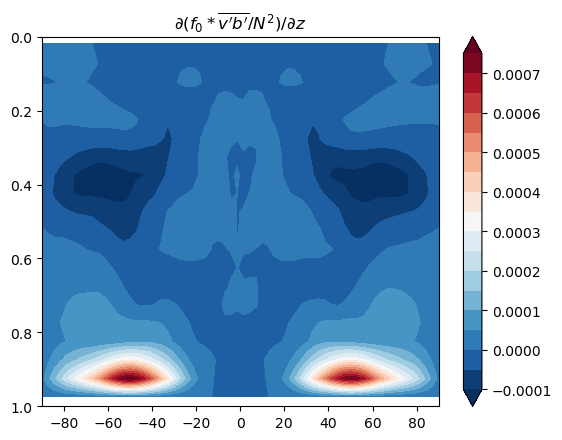

In [16]:
plt.figure()
plt.contourf(yy, sigma_mean2,  np.nanmean(q2, axis=0), levels=21, cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar()
plt.title("$\partial (f_0 * \overline{v'b'} / N^2) / \partial z$")

Text(0.5, 1.0, "$\\overline{v'q'}$")

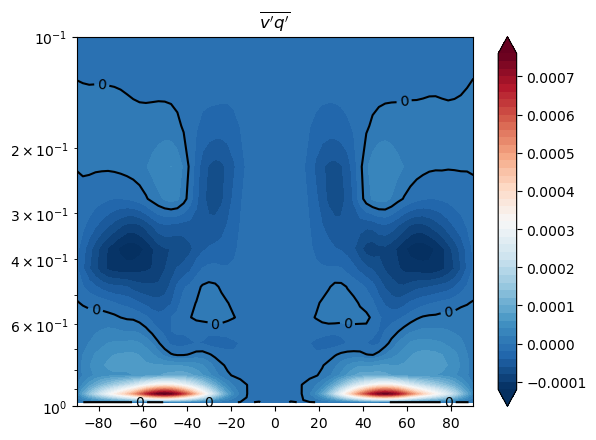

In [17]:
plt.figure()
plt.yscale('log')
plt.gca().invert_yaxis()
CS = plt.contourf(yy, sigma_mean2,  np.nanmean(q2+ dmdy, axis=0) , levels=51, cmap="RdBu_r", extend="both")
CT = plt.contour(yy, sigma_mean2,  np.nanmean(q2+ dmdy, axis=0) ,[0.0], colors='k')
plt.clabel(CT)
plt.ylim([1,0.1])
plt.colorbar(CS)
plt.title("$\overline{v'q'}$")

In [18]:
# q2[q2 == inf] = np.nan
vq_final = q2 + dmdy
vq_final_reshape = np.reshape(vq_final,(500,20*64))

vq_final_mean  = np.nanmean(vq_final_reshape, axis=0)
vq_final_minus = vq_final_reshape - vq_final_mean
print(np.isnan(q2).sum())


print(vq_final_reshape.shape)
print(vq_final_mean.shape)
print(vq_final_minus.shape)
print(vq_final_minus)

0
(500, 1280)
(1280,)
(500, 1280)
[[ 5.18088584e-07  1.65916864e-06  5.18835310e-06 ...  2.79092243e-07
  -1.72546201e-07 -3.47273292e-07]
 [-5.98060440e-07  1.91672821e-08 -6.04877445e-07 ...  8.28602786e-07
   2.98056072e-08 -2.66856784e-07]
 [ 1.61023006e-07  6.97538817e-07  3.86222143e-08 ...  2.41455707e-06
   8.28606458e-09 -2.54389872e-07]
 ...
 [ 9.13262805e-07  1.38464836e-06  1.59045519e-06 ...  9.46344497e-08
  -3.59473499e-07 -1.74442425e-06]
 [-5.42169149e-07  6.11928632e-07 -1.07188591e-06 ...  2.69459229e-06
   1.34713984e-06  2.31192761e-07]
 [-2.74473247e-07 -9.01139690e-07 -3.32935707e-06 ...  2.04837422e-06
   5.02730142e-07 -9.13929150e-07]]


In [19]:
z = np.zeros(u.shape)
print(np.arange(-1,21))
for i in range(1,20-1):
    z[:,i,:,:] = Rd*np.nanmean(t[:,0:i+1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
z[:, 0,:,:] = Rd*np.nanmean(t[:,0:1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,1,:,:])
z[:,-1,:,:] = Rd*np.nanmean(t[:,:,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,-1,:,:])

MHF_new = np.zeros(((500,22,64)))

for i in range(500):
    for j in range(64):
        fe             = interp1d(np.linspace(0,20,20), MHF[i,:,j],  fill_value='extrapolate')
        MHF_new[i,:,j] = fe(np.linspace(-1,21,22))

VHF = np.zeros(((500,20,64))) # vertical heat flux
H = 6800
for i in range(1,20-1):
    # z = Rd*np.nanmean(t[:,0:i,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
    VHF[:,i,:] = (MHF[:,i+1,:] - MHF[:,i-1,:])  / np.nanmean(z[:,i+1,:,:]-z[:,i-1,:,:], axis=(2)) 
print(VHF.shape)
# VHF[ :,0,:] = (MHF_new[ :,2,:] - MHF_new[ :,0,:])  / np.nanmean(z_new[:,2,:,:]-z_new[:,0,:,:], axis=(2)) 
# VHF[:,19,:] = (MHF_new[:,21,:] - MHF_new[:,19,:])  / np.nanmean(z_new[:,21,:,:]-z_new[:,19,:,:], axis=(2)) 

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
(500, 20, 64)


Text(0.5, 1.0, "$\\overline{v'b'} / N^2$")

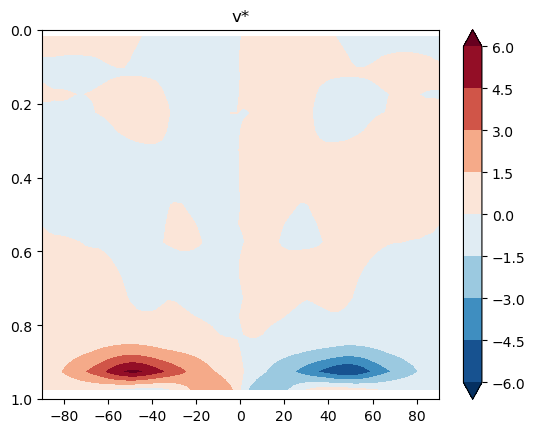

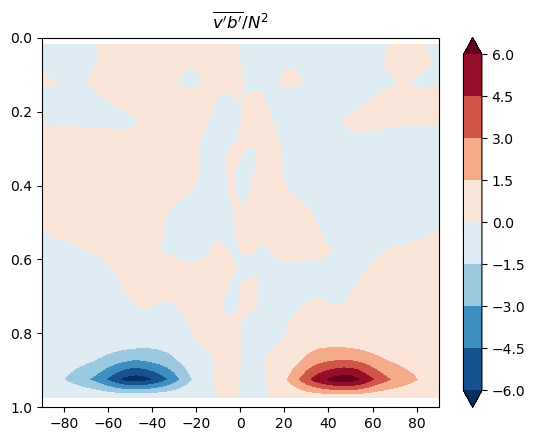

In [20]:
arr = np.nanmean(Vza * bza , axis=(3)) / np.nanmean(N_square, axis=(3))
arr2 = np.zeros(((500,20,64)))

for i in range(1,20-1):
    # z = Rd*np.nanmean(t[:,0:i,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
    arr2[:,i,:] = (arr[:,i+1,:] - arr[:,i-1,:])  / np.nanmean(z[:,i+1,:,:]-z[:,i-1,:,:], axis=(2)) 


###################################
v_w   = np.zeros(v.shape)
VHF_w = np.zeros(VHF.shape)

# for i in range(1,64-1):
#     v_w[:,:,i]   = v[:,:,i] * cy[i] ** 0.5
#     VHF_w[:,:,i] = VHF[:,:,i] * cy[i] ** 0.5
    
v_star = np.nanmean(v, axis=3) - VHF
plt.figure()
plt.contourf(yy, sigma_mean2,  np.nanmean(v_star, axis=(0)), levels=11, cmap="RdBu_r", extend="both")
plt.ylim([1,0])
# plt.yscale('log')
# plt.gca().invert_yaxis()
plt.colorbar()
plt.title("v*")

plt.figure()
plt.contourf(yy, sigma_mean2,  np.nanmean(VHF, axis=0), levels=12, cmap="RdBu_r", extend="both")
# plt.contourf(yy, sigma_mean2,  arr2, levels=12, cmap="RdBu_r", extend="both")

plt.ylim([1,0])
plt.colorbar()
plt.title("$\overline{v'b'} / N^2$")



(1280,)
(500, 1280)
0.9999999999999999
(500,) (500,)


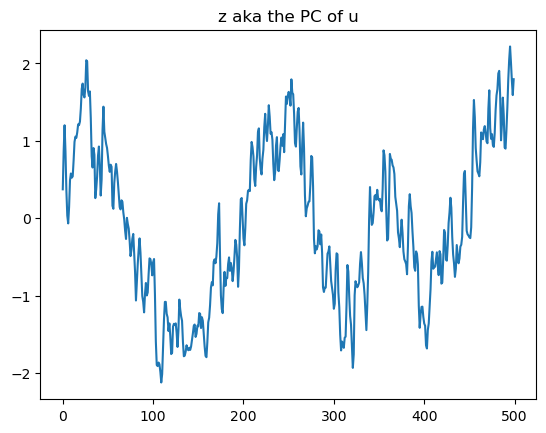

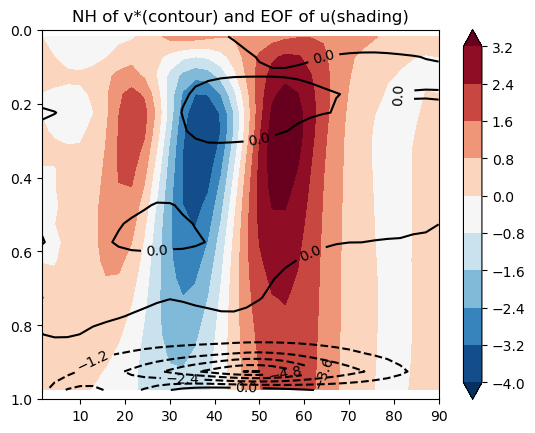

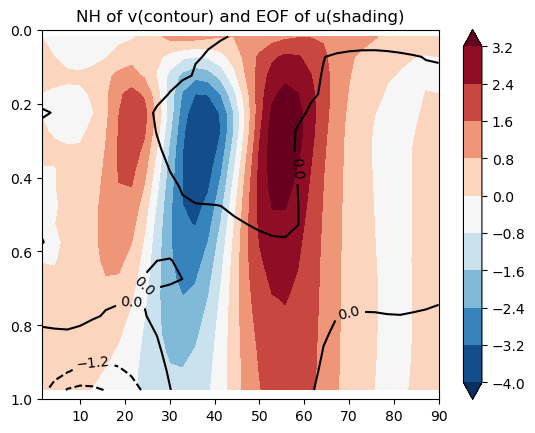

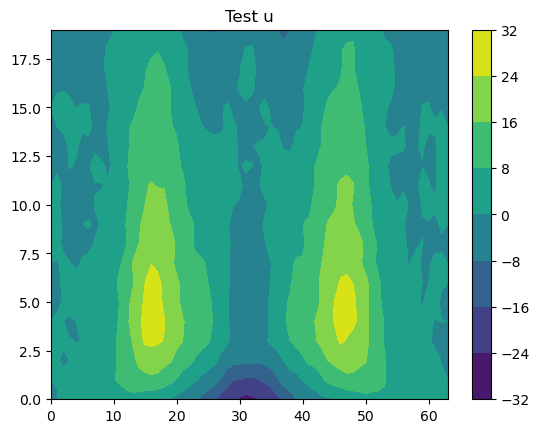

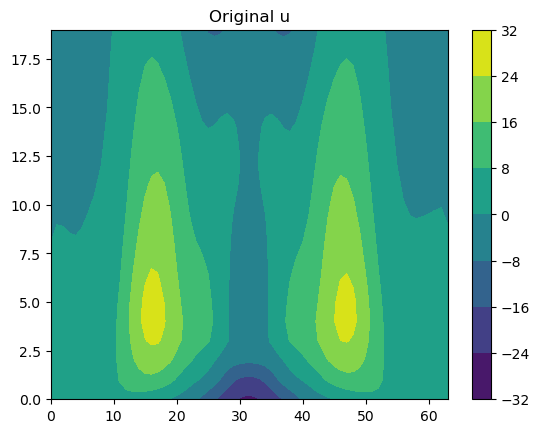

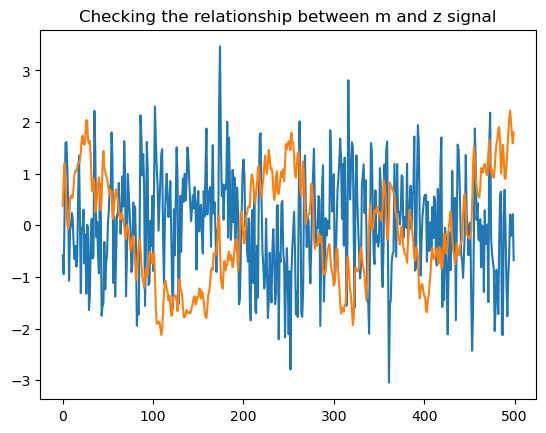

In [55]:
# Before EOF, we need to normalize final_m_term
from EOF import EOF
from scipy.fft import fft, ifft

u_50   = dycore.getVar("grid_u_c_xyzt")
u_50_w = np.zeros(u_50.shape)
for i in range(1,64-1): # cy[0] and [-1] are np.nan
    u_50_w[:,:,i,:] = u_50[:,:,i,:] * (cy[i])**0.5
u_50_w2   = np.nanmean(u_50_w[:,:,:,:], axis=(3))
u_50_new  = np.reshape(u_50_w2, (500, 20*64))
# print(u_50_new.shape)
###################################################


single_EOF_50 =  EOF((u_50_new,), n_components=500, field="1D")
single_EOF_50.get()

z_paper       = (single_EOF_50.PC[0,:])
EOF_try       = (single_EOF_50.EOF[0,:])

z_paper_std   = z_paper.std()
z_paper_final = z_paper / z_paper_std 

# plot for check whether I got correct EOF and PC, 
# so I project(do dot) EOF on PC to test if I would go back to original u wind.

plt.figure()
plt.plot(z_paper_final)
plt.title("z aka the PC of u") 


EOF_std = EOF_try.std()
EOF_try = EOF_try * z_paper_std 
EOF_back = np.reshape(EOF_try, (20,64))
plt.figure()
plt.contourf(yy[:,32:], sigma_mean2[:,32:],  EOF_back[:,32:], levels=11, cmap="RdBu_r", extend="both")
plt.colorbar()
plt.ylim([1,0])
# plt.title("EOF of u") 
# plt.figure()
CS = plt.contour(yy[:,32:], sigma_mean2[:,32:],  np.nanmean(v_star, axis=(0))[:,32:], levels=np.linspace(-6,6,11), colors='k')
plt.clabel(CS)
plt.ylim([1,0])
# plt.colorbar()
plt.title("NH of v*(contour) and EOF of u(shading)")

print(EOF_try.shape)
print(vq_final_minus.shape)
# m = np.dot(EOF_try[3:-3], vq_final_minus[:,3:-3].T)
f0v = np.zeros(((500,20,64)))
v  = dycore.getVar("grid_v_c_xyzt")
v_mean = np.nanmean(v, axis=3)
for i in range(64):
    f0v[:,:,i] = v_mean[:,:,i] * f0[i]
f0v_reshape = np.reshape(f0v, (500,20*64))
f0v_minus   = f0v_reshape - np.nanmean(f0v_reshape, axis=0)
# print(f0v_star_minus.shape)
# m_right = f0v_star_minus + vq_final_minus

m_right = f0v_reshape #+ vq_final_reshape ###########################################
m_right_final = m_right - np.nanmean(m_right, axis=0)

plt.figure()
plt.contourf(yy[:,32:], sigma_mean2[:,32:],  EOF_back[:,32:], levels=11, cmap="RdBu_r", extend="both")
plt.colorbar()
plt.ylim([1,0])
# plt.title("EOF of u") 
# plt.figure()
CS2 = plt.contour(yy[:,32:], sigma_mean2[:,32:],  np.nanmean(v_mean[:,:,32:],axis=0), levels=np.linspace(-6,6,11), colors='k')
plt.clabel(CS2)
plt.ylim([1,0])
# plt.colorbar()
plt.title("NH of v(contour) and EOF of u(shading)")


#### original ####
m = np.zeros(500)
for i in range(500):
    m[i] = np.nansum(EOF_try[2:-2]*m_right_final[i,2:-2].T)
##################
# m = np.zeros(500)
# for i in range(500):
#     m[i] = np.nansum(EOF_try[2:-2]*f0Vzm_reshape_minus[i,2:-2].T)

# m = m * 30 * 86400 /np.pi
m_std   = m.std()
m_final = m / m_std
# print(m_final)

print(np.std(m_final))
plt.figure()
test = (single_EOF_50.EOF.T.dot(single_EOF_50.PC)).T
test_mean = np.nanmean(test, axis=0)
test_final = np.reshape(test_mean, (20,64))
CS1 = plt.contourf(test_final)

plt.title("Test u") 
plt.colorbar(CS1)

plt.figure()
u_50_new_mean = np.nanmean(u_50_new, axis=0)
u_50_new_final = np.reshape(u_50_new_mean, (20,64))
CS2 = plt.contourf(u_50_new_final)
plt.title("Original u") 
plt.colorbar(CS2)


plt.figure()
plt.title("Checking the relationship between m and z signal") 
print(m_final.shape, z_paper_final.shape)
plt.plot(m_final)
plt.plot(z_paper_final)


(0.02909333587719052+0.04084404291898146j)
(0.03439569576922718+0.0038894175265867595j)
[-0.11207317+0.j         -1.41844039-0.35664133j -0.08460736-1.23401106j
 -2.48659198-3.58054392j  9.20386074-4.51688364j -0.59299645-1.4578648j
  2.02481337+8.73077205j -4.66796734-4.00129571j  1.12811267-0.69913527j
 -3.91519999+2.05290733j -2.59968227+0.j         -3.91519999-2.05290733j
  1.12811267+0.69913527j -4.66796734+4.00129571j  2.02481337-8.73077205j
 -0.59299645+1.4578648j   9.20386074+4.51688364j -2.48659198+3.58054392j
 -0.08460736+1.23401106j -1.41844039+0.35664133j]


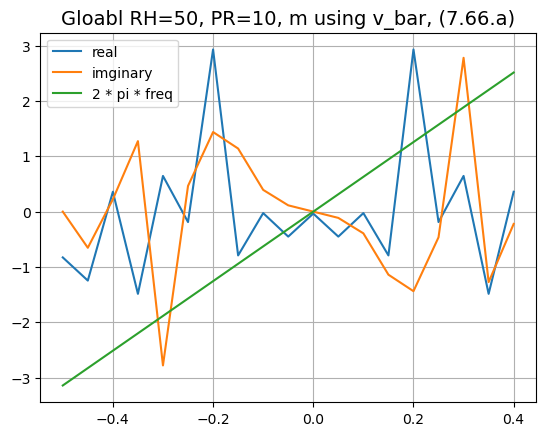

In [56]:
# Do not take the all time series to do FFT,
# there would be offset. So I'm gotta to take the small time interval to do FFT, 
# which are overlap (because after FFT, there would be a pulse at both ends of the spectrum space.
lg      = 20 # length of interval 
Z_sum   = np.zeros(lg, dtype = complex)
M_sum   = np.zeros(lg, dtype = complex)

for i in range(0 , len(z), lg):
    if i == 0:
        aa = i
        Z_sum += fft(z_paper_final[0:aa+lg])  / len(z_paper_final[0:aa+lg])     #要除以資料長度
        M_sum += fft(m_final[0:aa+lg])  / len(m_final[0:aa+lg])
    else:
        aa = int(i-10)   
        Z_sum += fft(z_paper_final[aa:aa+lg]) / len(z_paper_final[aa:aa+lg])    #要除以資料長度
        M_sum += fft(m_final[aa:aa+lg]) / len(m_final[aa:aa+lg])
        # print(np.nanmin(Z_sum))
    
# print((len(Z) / lg))
Z = Z_sum / (len(z_paper) / lg)
M = M_sum / (len(m) / lg)
print(np.nanmax(Z))
print(np.nanmax(M))
# print(Z_final)

freq   = fftfreq(Z.shape[0])
idx    = np.argsort(freq)

M_star = np.conjugate(M)
Z_star = np.conjugate(Z)

final  = (Z_star * M) / (Z_star * Z)

kk     = -1  #int(lg)
ll     = 0   #int(lg/2-2)
print(final)
plt.figure(dpi=100.)
plt.title("Gloabl RH=50, PR=10, m using v_bar, (7.66.a)", fontsize=14)
plt.plot(freq[idx][ll:kk], (final[idx][ll:kk]).real / np.pi, label="real")
plt.plot(freq[idx][ll:kk], (final[idx][ll:kk]).imag / np.pi, label="imginary")
plt.plot(freq[idx][ll:kk], (freq[idx][ll:kk]) * 2 * np.pi, label="2 * pi * freq")

# plt.xlim([-0.01, 0.25])
# plt.ylim([-0.05,1.75])
plt.grid()
plt.legend()
# plt.savefig(r"paper1_fig/eq(7.66a)_fig/RH50_PR10//Global_v_cross_spectrum.png", bbox_inches='tight', dpi=600.)
plt.show()


In [57]:
# do SH v cross spetrum
### do SM
### edited for EOF, changing the dimension to (day, 20, 64) to do baroclinc annular mode
day = 500
q2_sm = np.zeros(((day,20,32)))
for i in range(1,20-1):
    q2_sm[:,i,:] = (MHF_f[:,i+1,:32] - MHF_f[:,i-1,:32])  / np.nanmean(z[:,i+1,:32,:]-z[:,i-1,:32,:], axis=(0,2)) 
MHF_f_new = np.zeros(((day,22,64)))

for i in range(day):
    for j in range(32):
        fe             = interp1d(np.linspace(0,20,20), MHF_f[i,:,j],  fill_value='extrapolate')
        MHF_f_new[i,:,j] = fe(np.linspace(-1,21,22))

# q2[ 0,:] = (MHF_f_new[ 2,:] - MHF_f_new[ 0,:])  / np.nanmean(z_new[:,2,:,:]-z_new[:,0,:,:], axis=(0,2)) 
# q2[19,:] = (MHF_f_new[21,:] - MHF_f_new[19,:])  / np.nanmean(z_new[:,21,:,:]-z_new[:,19,:,:], axis=(0,2)) 
#
# q2[q2 == inf] = np.nan
vq_final_sm = q2_sm + dmdy[:,:,:32]
vq_final_sm_reshape = np.reshape(vq_final_sm,(day,20*32))

vq_final_sm_mean  = np.nanmean(vq_final_sm_reshape, axis=0)
vq_final_sm_minus = vq_final_sm_reshape - vq_final_sm_mean
#


# MHF_new = np.zeros(((day,22,64)))

# for i in range(day):
#     for j in range(64):
#         fe             = interp1d(np.linspace(0,20,20), MHF[i,:,j],  fill_value='extrapolate')
#         MHF_new[i,:,j] = fe(np.linspace(-1,21,22))

VHF_sm = np.zeros(((day,20,32))) # vertical heat flux
for i in range(1,20-1):
    VHF_sm[:,i,:] = (MHF[:,i+1,:32] - MHF[:,i-1,:32])  / np.nanmean(z[:,i+1,:32,:]-z[:,i-1,:32,:], axis=(2)) 
# VHF[ :,0,:] = (MHF_new[ :,2,:] - MHF_new[ :,0,:])  / np.nanmean(z_new[:,2,:,:]-z_new[:,0,:,:], axis=(2)) 
# VHF[:,19,:] = (MHF_new[:,21,:] - MHF_new[:,19,:])  / np.nanmean(z_new[:,21,:,:]-z_new[:,19,:,:], axis=(2)) 

v_star_sm = np.nanmean(v[:,:,:32,:], axis=3) - VHF_sm
print("over")

over


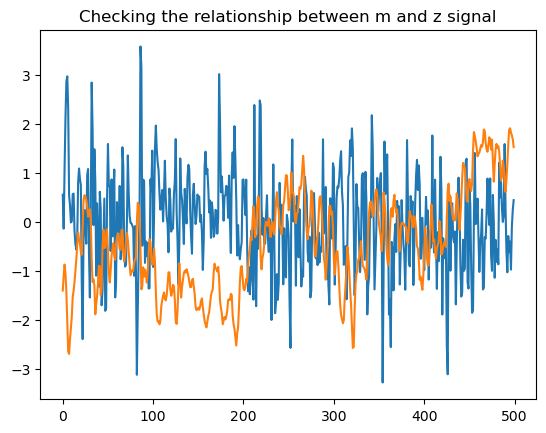

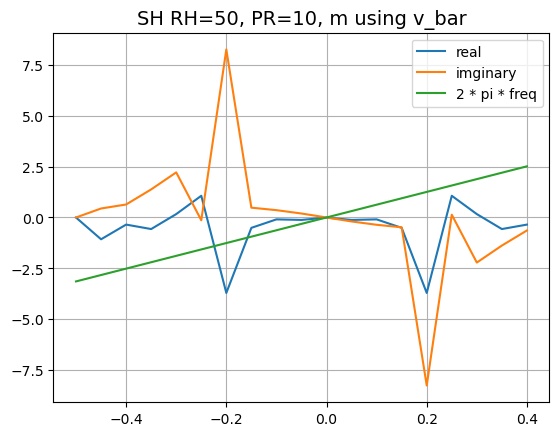

In [51]:
### do Southern Hemsiphere
# Before EOF, we need to normalize final_m_term
u_50   = dycore.getVar("grid_u_c_xyzt")
u_50_w_sm = np.zeros((((day,20,32,128))))
for i in range(1,32): # cy[0] and [-1] are np.nan
    u_50_w_sm[:,:,i,:] = u_50[:,:,i,:] * (cy[i])**0.5
u_50_w2_sm   = np.nanmean(u_50_w_sm[:,:,:,:], axis=(3))
u_50_new_sm  = np.reshape(u_50_w2_sm, (day, 20*32))
# print(u_50_new.shape)
###################################################


single_EOF_50 =  EOF((u_50_new_sm,), n_components=500, field="1D")
single_EOF_50.get()

z_paper_sm       = (single_EOF_50.PC[0,:])
EOF_try_sm       = (single_EOF_50.EOF[0,:])

z_paper_sm_std   = z_paper_sm.std()
z_paper_sm_final = z_paper_sm / z_paper_sm_std 

# plot for check whether I got correct EOF and PC, 
# so I project(do dot) EOF on PC to test if I would go back to original u wind.

EOF_sm_std = EOF_try_sm.std()
EOF_try_sm = EOF_try_sm * z_paper_sm_std 
EOF_back_sm = np.reshape(EOF_try_sm, (20,32))

f0v_sm = np.zeros(((day,20,32)))
v_mean = np.nanmean(v, axis=3)
for i in range(32):
    f0v_sm[:,:,i] = v_mean[:,:,i] * f0[i]
f0v_sm_reshape = np.reshape(f0v_sm, (day,20*32))
f0v_sm_minus   = f0v_sm_reshape - np.nanmean(f0v_sm_reshape, axis=0)
m_right_sm = f0v_sm_reshape #+ vq_final_sm_reshape
m_right_final_sm = m_right_sm - np.nanmean(m_right_sm, axis=0)

m_sm = np.zeros(day)
for i in range(day):
    m_sm[i] = np.nansum(EOF_try_sm[2:-2]*m_right_final_sm[i,2:-2].T)

m_sm_std   = m_sm.std()
m_sm_final = m_sm / m_sm_std
plt.figure()
plt.title("Checking the relationship between m and z signal") 
plt.plot(m_sm_final)
plt.plot(z_paper_sm_final)
# Do not take the all time series to do FFT,
# there would be offset. So I'm gotta to take the small time interval to do FFT, 
# which are overlap (because after FFT, there would be a pulse at both ends of the spectrum space.
lg      = 20 # length of interval 
Z_sum   = np.zeros(lg, dtype = complex)
M_sum   = np.zeros(lg, dtype = complex)

for i in range(0 , len(z), lg):
    if i == 0:
        aa = i
        Z_sum += fft(z_paper_sm_final[0:aa+lg])  / len(z_paper_sm_final[0:aa+lg])     #要除以資料長度
        M_sum += fft(m_sm_final[0:aa+lg])  / len(m_sm_final[0:aa+lg])
    else:
        aa = int(i-10)   
        Z_sum += fft(z_paper_sm_final[aa:aa+lg]) / len(z_paper_sm_final[aa:aa+lg])    #要除以資料長度
        M_sum += fft(m_sm_final[aa:aa+lg]) / len(m_sm_final[aa:aa+lg])
        # print(np.nanmin(Z_sum))

# print((len(Z) / lg))
Z = Z_sum / (len(z_paper_sm_final) / lg)
M = M_sum / (len(m_sm_final) / lg)
# print(Z_final)

freq   = fftfreq(Z.shape[0])
idx    = np.argsort(freq)

M_star = np.conjugate(M)
Z_star = np.conjugate(Z)

final  = (Z_star * M) / (Z_star * Z)

kk     = -1  #int(lg)
ll     = 0   #int(lg/2-2)
plt.figure(dpi=100.)
plt.title("SH RH=50, PR=10, m using v_bar", fontsize=14)
plt.plot(freq[idx][ll:kk], (final[idx][ll:kk]).real / np.pi, label="real")
plt.plot(freq[idx][ll:kk], (final[idx][ll:kk]).imag / np.pi, label="imginary")
plt.plot(freq[idx][ll:kk], (freq[idx][ll:kk]) * 2 * np.pi, label="2 * pi * freq")

# plt.xlim([-0.01, 0.25])
# plt.ylim([-0.05,1.75])
plt.grid()
plt.legend()
# plt.savefig(r"paper1_fig/eq(7.66a)_fig/RH50_PR10//SH_v_cross_spectrum.png", bbox_inches='tight', dpi=600.)
plt.show()

In [59]:
### do NM
### edited for EOF, changing the dimension to (day, 20, 64) to do baroclinc annular mode

q2_nm = np.zeros(((day,20,32)))
for i in range(1,20-1):
    q2_nm[:,i,:] = (MHF_f[:,i+1,32:] - MHF_f[:,i-1,32:])  / np.nanmean(z[:,i+1,32:,:]-z[:,i-1,32:,:], axis=(0,2)) 
MHF_f_new = np.zeros(((day,22,64)))

for i in range(day):
    for j in range(32):
        fe             = interp1d(np.linspace(0,20,20), MHF_f[i,:,j+32],  fill_value='extrapolate')
        MHF_f_new[i,:,j] = fe(np.linspace(-1,21,22))

# q2[ 0,:] = (MHF_f_new[ 2,:] - MHF_f_new[ 0,:])  / np.nanmean(z_new[:,2,:,:]-z_new[:,0,:,:], axis=(0,2)) 
# q2[19,:] = (MHF_f_new[21,:] - MHF_f_new[19,:])  / np.nanmean(z_new[:,21,:,:]-z_new[:,19,:,:], axis=(0,2)) 
#
# q2[q2 == inf] = np.nan
vq_final_nm = q2_nm + dmdy[:,:,32:]
vq_final_nm_reshape = np.reshape(vq_final_nm,(day,20*32))

vq_final_nm_mean  = np.nanmean(vq_final_nm_reshape, axis=0)
vq_final_nm_minus = vq_final_nm_reshape - vq_final_nm_mean
#


# MHF_new = np.zeros(((day,22,64)))

# for i in range(day):
#     for j in range(64):
#         fe             = interp1d(np.linspace(0,20,20), MHF[i,:,j],  fill_value='extrapolate')
#         MHF_new[i,:,j] = fe(np.linspace(-1,21,22))

VHF_nm = np.zeros(((day,20,32))) # vertical heat flux
for i in range(1,20-1):
    VHF_nm[:,i,:] = (MHF[:,i+1,32:] - MHF[:,i-1,32:])  / np.nanmean(z[:,i+1,32:,:]-z[:,i-1,32:,:], axis=(2)) 
# VHF[ :,0,:] = (MHF_new[ :,2,:] - MHF_new[ :,0,:])  / np.nanmean(z_new[:,2,:,:]-z_new[:,0,:,:], axis=(2)) 
# VHF[:,19,:] = (MHF_new[:,21,:] - MHF_new[:,19,:])  / np.nanmean(z_new[:,21,:,:]-z_new[:,19,:,:], axis=(2)) 

v_star_nm = np.nanmean(v[:,:,32:,:], axis=3) - VHF_nm
print("over")

over


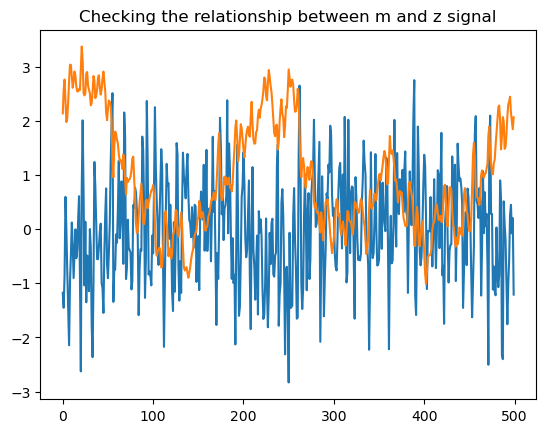

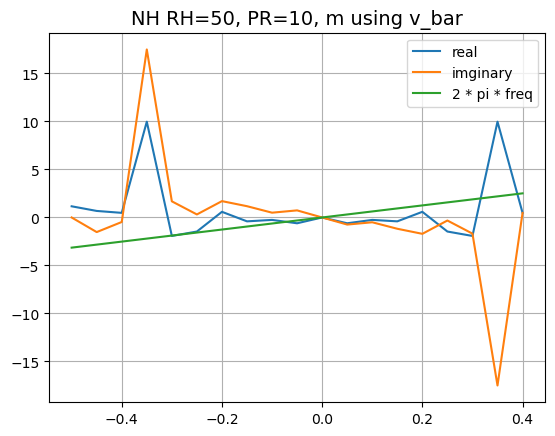

In [62]:
### do Northen Hemsiphere
# Before EOF, we need to normalize final_m_term
u_50   = dycore.getVar("grid_u_c_xyzt")
u_50_w_nm = np.zeros((((day,20,32,128))))
for i in range(1,32): # cy[0] and [-1] are np.nan
    u_50_w_nm[:,:,i,:] = u_50[:,:,i+32,:] * (cy[i])**0.5
u_50_w2_nm   = np.nanmean(u_50_w_nm[:,:,:,:], axis=(3))
u_50_new_nm  = np.reshape(u_50_w2_nm, (day, 20*32))
# print(u_50_new.shape)
###################################################


single_EOF_50 =  EOF((u_50_new_nm,), n_components=500, field="1D")
single_EOF_50.get()

z_paper_nm       = (single_EOF_50.PC[0,:])
EOF_try_nm       = (single_EOF_50.EOF[0,:])

z_paper_nm_std   = z_paper_nm.std()
z_paper_nm_final = z_paper_nm / z_paper_nm_std 

# plot for check whether I got correct EOF and PC, 
# so I project(do dot) EOF on PC to test if I would go back to original u wind.

EOF_nm_std = EOF_try_nm.std()
EOF_try_nm = EOF_try_nm * z_paper_nm_std 
EOF_back_nm = np.reshape(EOF_try_nm, (20,32))

f0v_nm = np.zeros(((day,20,32)))
v_mean = np.nanmean(v, axis=3)
for i in range(32):
    f0v_nm[:,:,i] = v_mean[:,:,i+32] * f0[i+32]
f0v_nm_reshape = np.reshape(f0v_nm, (day,20*32))
f0v_nm_minus   = f0v_nm_reshape - np.nanmean(f0v_nm_reshape, axis=0)
m_right_nm = f0v_nm_reshape #+ vq_final_nm_reshape
m_right_final_nm = m_right_nm - np.nanmean(m_right_nm, axis=0)

m_nm = np.zeros(day)
for i in range(day):
    m_nm[i] = np.nansum(EOF_try_nm[2:-2]*m_right_final_nm[i,2:-2].T)

m_nm_std   = m_nm.std()
m_nm_final = m_nm / m_nm_std
plt.figure()
plt.title("Checking the relationship between m and z signal") 
plt.plot(m_nm_final)
plt.plot(z_paper_nm_final)
# Do not take the all time series to do FFT,
# there would be offset. So I'm gotta to take the small time interval to do FFT, 
# which are overlap (because after FFT, there would be a pulse at both ends of the spectrum space.
lg      = 20 # length of interval 
Z_sum   = np.zeros(lg, dtype = complex)
M_sum   = np.zeros(lg, dtype = complex)

for i in range(0 , len(z), lg):
    if i == 0:
        aa = i
        Z_sum += fft(z_paper_nm_final[0:aa+lg])  / len(z_paper_nm_final[0:aa+lg])     #要除以資料長度
        M_sum += fft(m_nm_final[0:aa+lg])  / len(m_nm_final[0:aa+lg])
    else:
        aa = int(i-10)   
        Z_sum += fft(z_paper_nm_final[aa:aa+lg]) / len(z_paper_nm_final[aa:aa+lg])    #要除以資料長度
        M_sum += fft(m_nm_final[aa:aa+lg]) / len(m_nm_final[aa:aa+lg])
        # print(np.nanmin(Z_sum))

# print((len(Z) / lg))
Z = Z_sum / (len(z_paper_nm_final) / lg)
M = M_sum / (len(m_nm_final) / lg)
# print(Z_final)

freq   = fftfreq(Z.shape[0])
idx    = np.argsort(freq)

M_star = np.conjugate(M)
Z_star = np.conjugate(Z)

final  = (Z_star * M) / (Z_star * Z)

kk     = -1  #int(lg)
ll     = 0   #int(lg/2-2)
plt.figure(dpi=100.)
plt.title("NH RH=50, PR=10, m using v_bar", fontsize=14)
plt.plot(freq[idx][ll:kk], (final[idx][ll:kk]).real / np.pi, label="real")
plt.plot(freq[idx][ll:kk], (final[idx][ll:kk]).imag / np.pi, label="imginary")
plt.plot(freq[idx][ll:kk], (freq[idx][ll:kk]) * 2 * np.pi, label="2 * pi * freq")

# plt.xlim([-0.4, 0.4])
# plt.ylim([-3,3])
plt.grid()
plt.legend()
# plt.savefig(r"paper1_fig/eq(7.66a)_fig/RH50_PR10//NH_v_cross_spectrum.png", bbox_inches='tight', dpi=600.)
plt.show()